# Project 1: Gradient-based Algorithms and Differentiable Programming


## 1. Introduction
Consider a simple formulation of rocket landing where the rocket state $x(t)$ is represented by its distance to the ground $d(t)$ and its velocity $v(t)$, i.e., $x(t) = [d(t), v(t)]^T$, where $t$ specifies time. The control input of the rocket is its acceleration $a(t)$. The discrete-time dynamics follows 

$$
\begin{aligned}
d(t+1) = d(t) + v(t) \Delta t, \\
v(t+1) = v(t) + a(t) \Delta t,
\end{aligned}
$$

where $\Delta t$ is a time interval. Further, let the closed-loop controller be 

$$
a(t) = f_{\theta}(x(t))
$$

where $f_{\theta}(\cdot)$ is a neural network with parameters $\theta$, which are to be determined through optimization.

For each time step, we assign a loss as a function of the control input and the state: $l(x(t),a(t))$. In this example, we will simply set $l(x(t),a(t))=0$ for all $t=1,...,T-1$, where $T$ is the final time step, and $l(x(T),a(T)) = ||x(T)||^2 = d(T)^2 + v(T)^2$. This loss encourages the rocket to reach $d(T)=0$ and $v(T)=0$, which are proper landing conditions.

The optimization problem is now formulated as

$$
\begin{aligned}
\min_{\theta} \quad & ||x(T)||^2 \\
\quad & d(t+1) = d(t) + v(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1
\end{aligned}
$$

While this problem is constrained, it is easy to see that the objective function can be expressed as a function of $x(T-1) and a(T-1)$, where $x(T-1)$ as a function of $x(T-2)$ and $a(T-2)$, and so on. Thus it is essentially an unconstrained problem with respect to $\theta$. 

In the following, we code this problem up with [PyTorch](https://pytorch.org/), which allows us to only build the forward pass of the loss (i.e., how we move from $x(1)$ to $x(2)$ and all the way to $x(T)$) and automatically get the gradient $\nabla_{\theta} l(x(T),a(T))$.

---

## 2. Sample Code

Before you start, please make sure you install the PyTorch package in Python. If you are using Pycharm, you can do so through *setting*->*Project: Your Project Name*->*Project Interpreter*->*Install (the little plus sign to the right of the window)*. 

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[1] loss: 253492.125


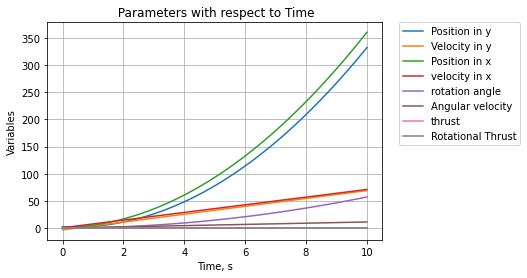

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[2] loss: 253490.750


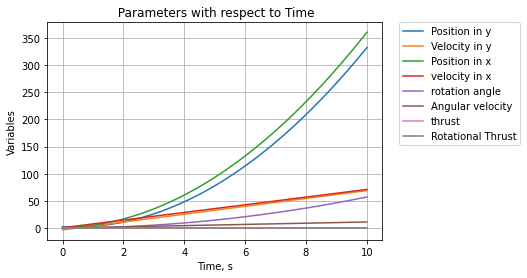

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[3] loss: 253487.781


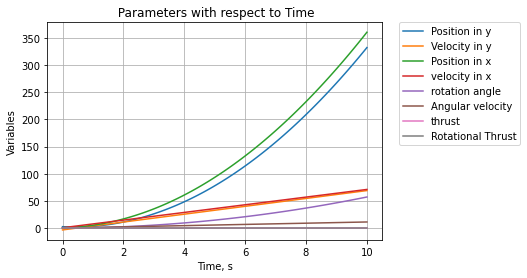

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[4] loss: 253475.438


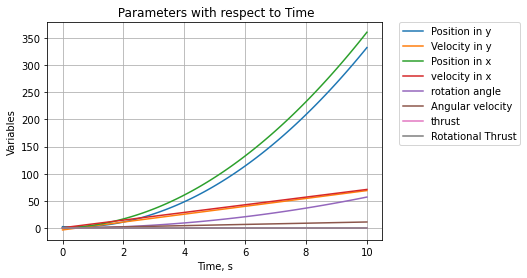

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[5] loss: 250996.219


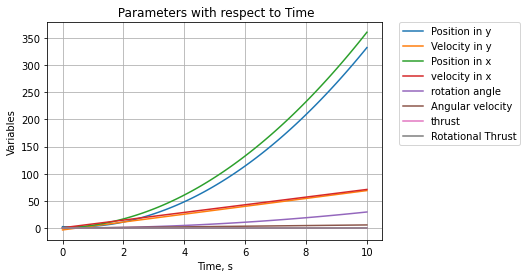

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[6] loss: 250904.688


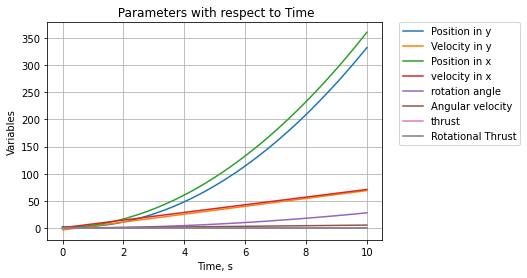

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[7] loss: 250834.281


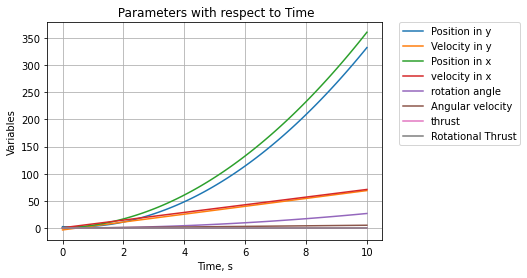

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[8] loss: 250778.875


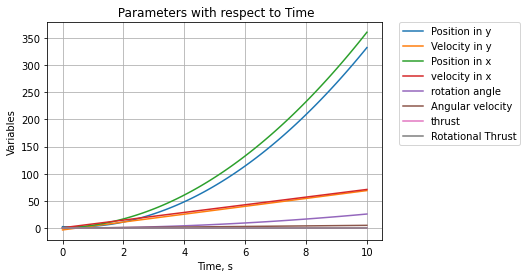

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[9] loss: 250734.688


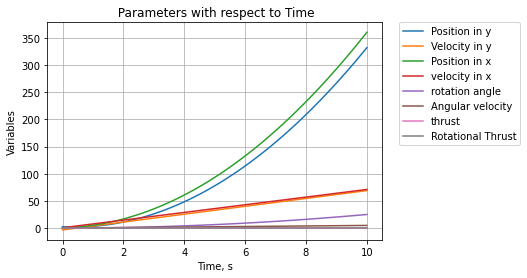

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[10] loss: 250699.062


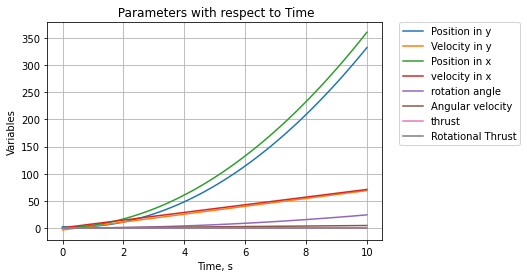

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[11] loss: 250670.219


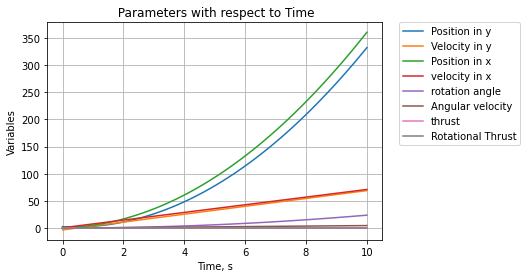

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[12] loss: 250646.719


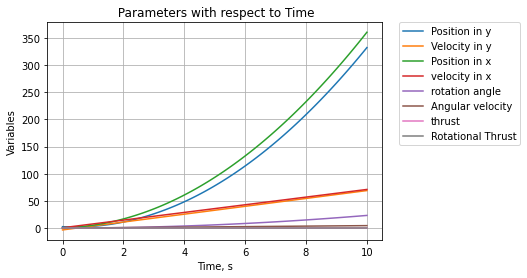

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[13] loss: 250627.531


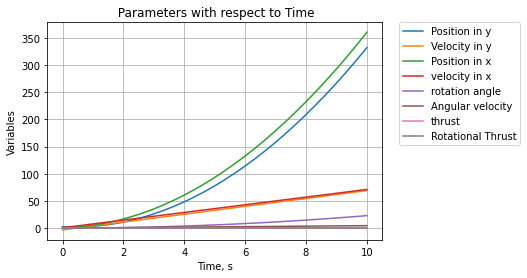

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[14] loss: 250611.844


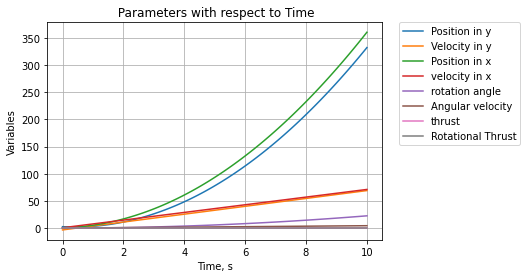

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[15] loss: 250599.000


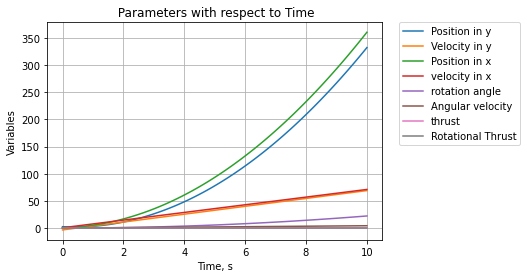

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[16] loss: 250588.469


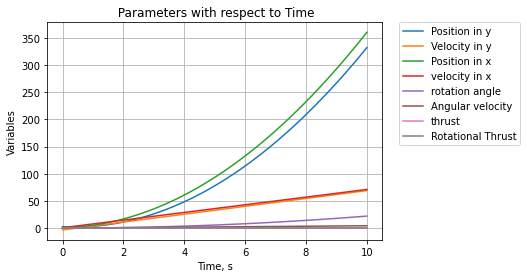

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[17] loss: 250579.844


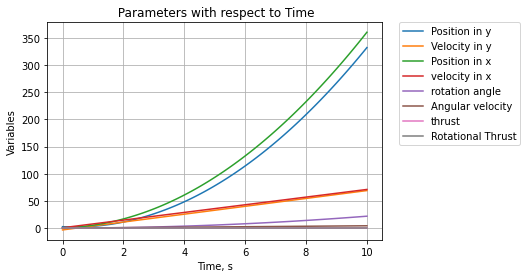

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[18] loss: 250572.781


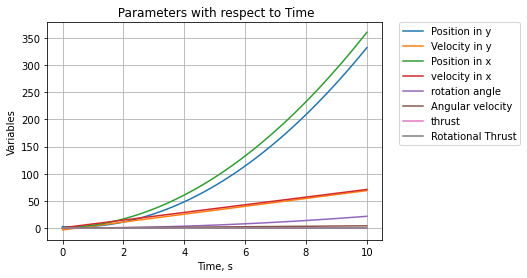

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[19] loss: 250566.969


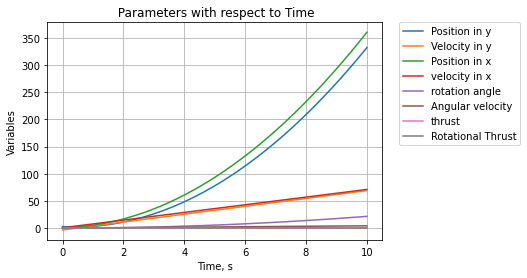

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[20] loss: 250562.188


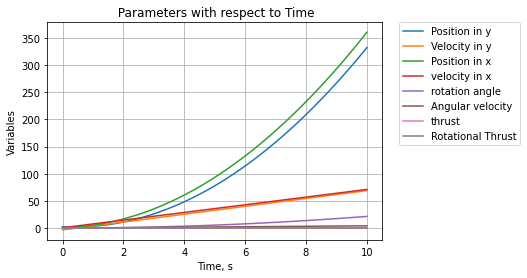

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[21] loss: 250558.281


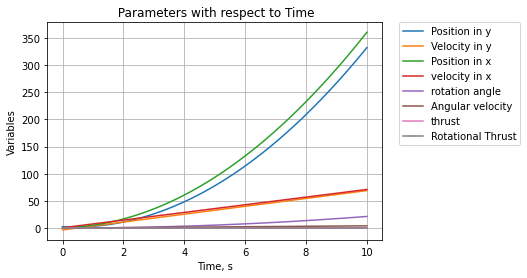

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[22] loss: 250555.094


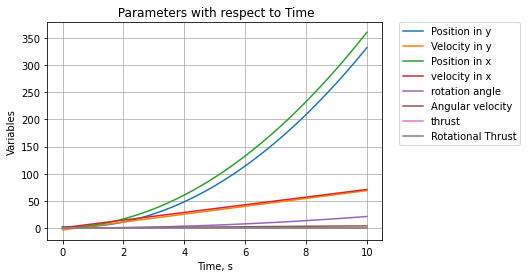

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[23] loss: 250552.469


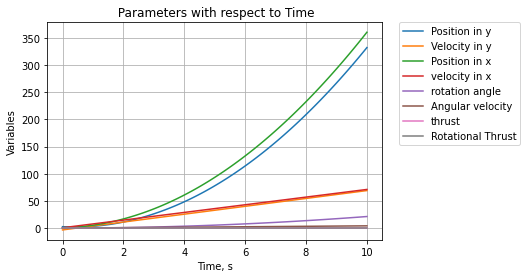

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[24] loss: 250550.312


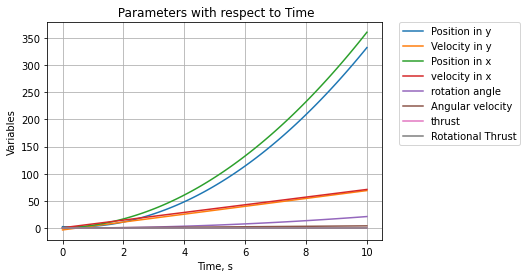

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[25] loss: 250548.562


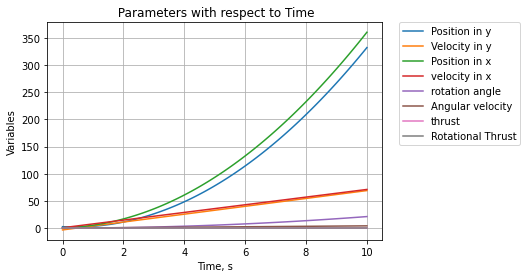

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[26] loss: 250547.094


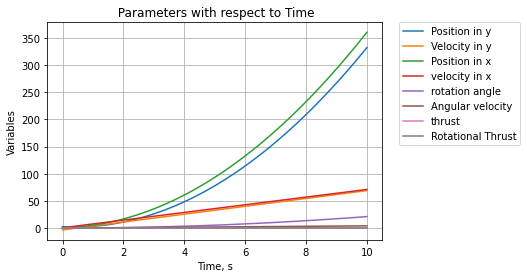

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[27] loss: 250545.906


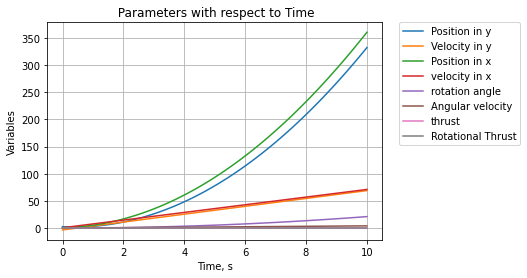

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[28] loss: 250544.938


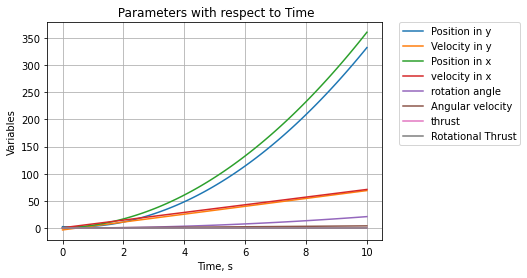

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[29] loss: 250544.125


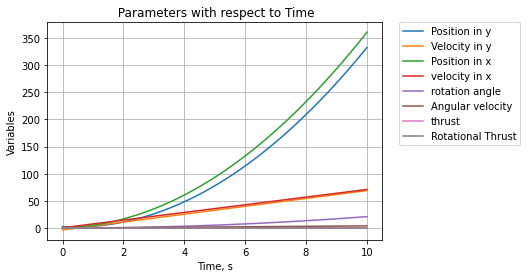

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[30] loss: 250543.562


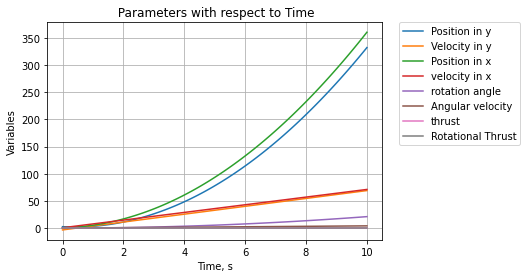

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[31] loss: 250543.469


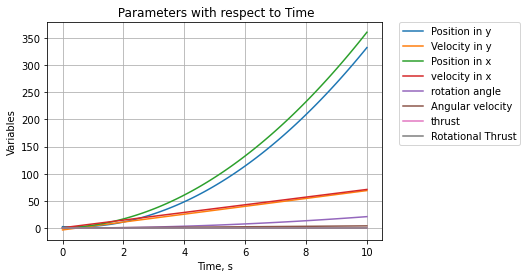

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[32] loss: 250543.219


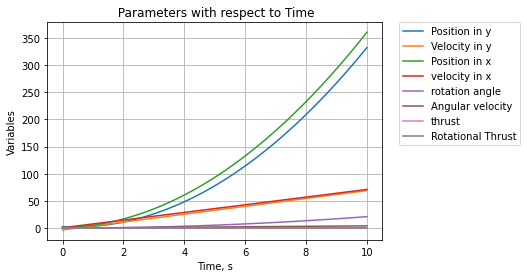

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[33] loss: 250543.062


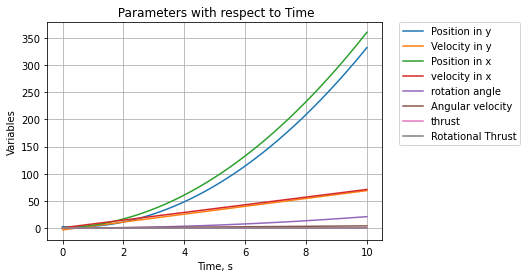

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[34] loss: 250542.938


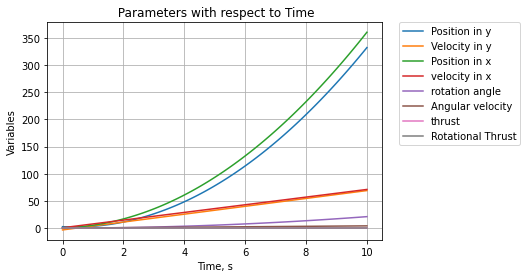

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[35] loss: 250542.844


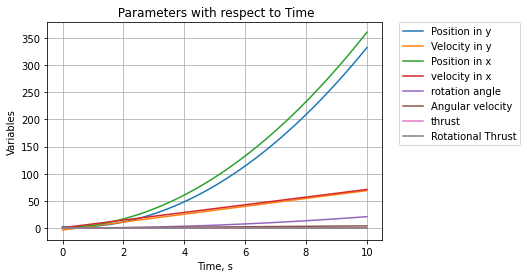

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[36] loss: 250542.781


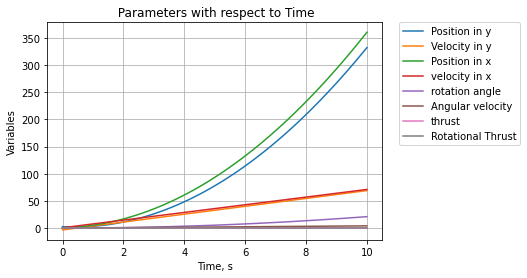

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[37] loss: 250542.688


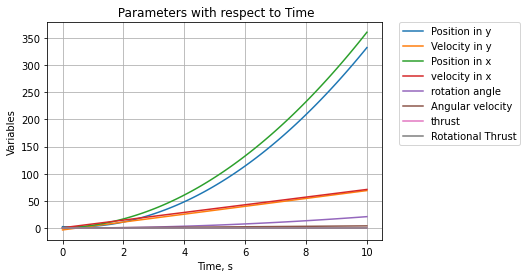

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[38] loss: 250542.625


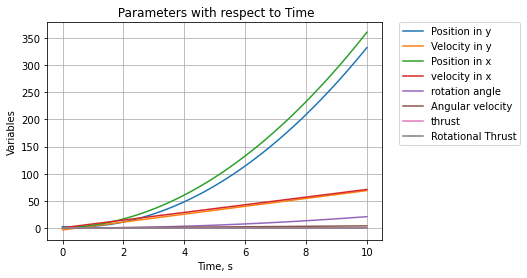

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[39] loss: 250542.562


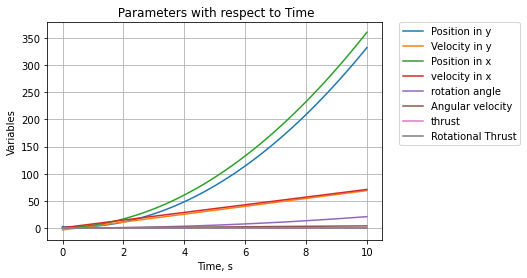

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[40] loss: 250542.500


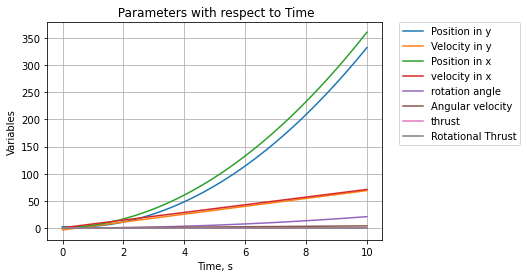

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[41] loss: 250542.438


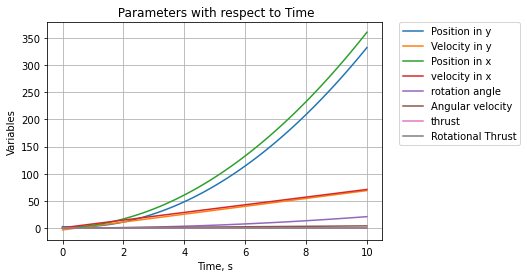

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[42] loss: 250542.406


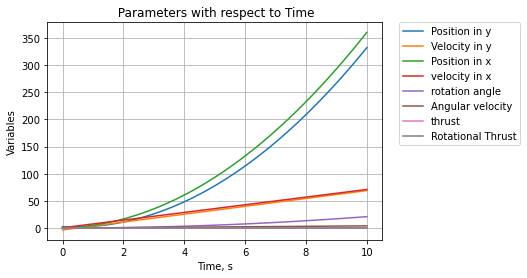

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[43] loss: 250542.344


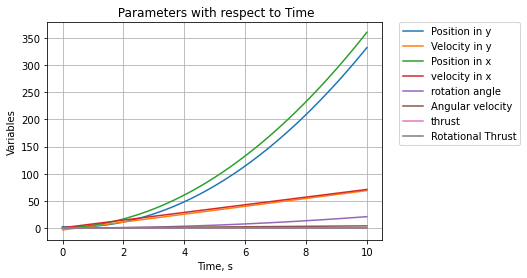

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[44] loss: 250542.312


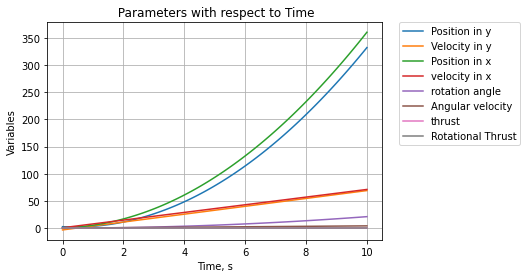

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[45] loss: 250542.250


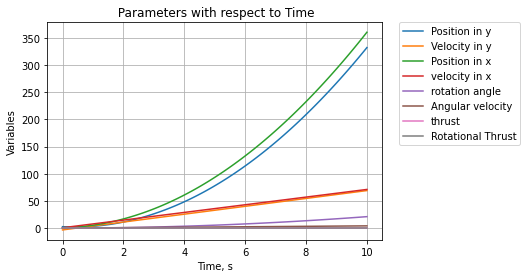

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[46] loss: 250542.219


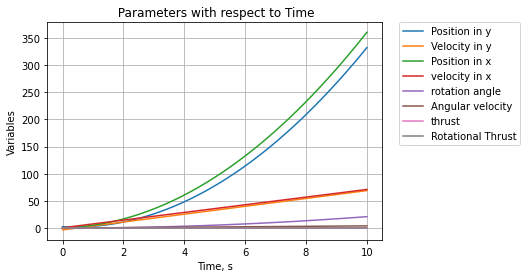

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[47] loss: 250542.188


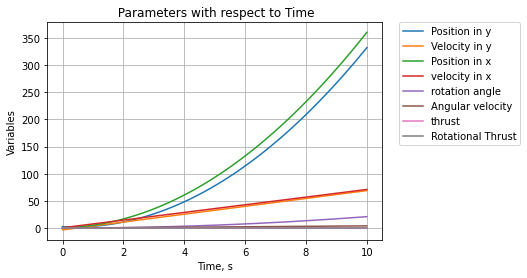

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[48] loss: 250542.156


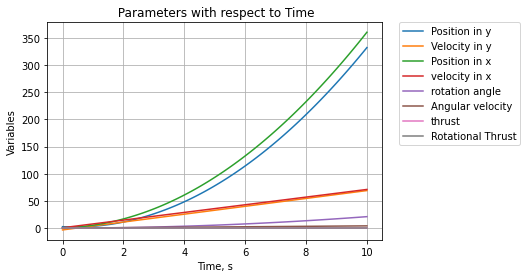

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[49] loss: 250542.125


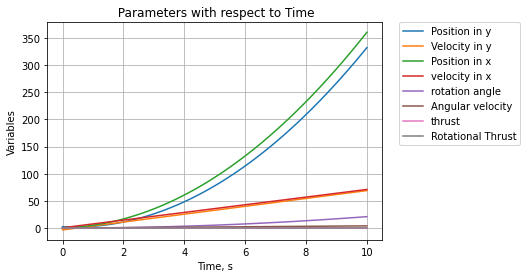

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[50] loss: 250542.094


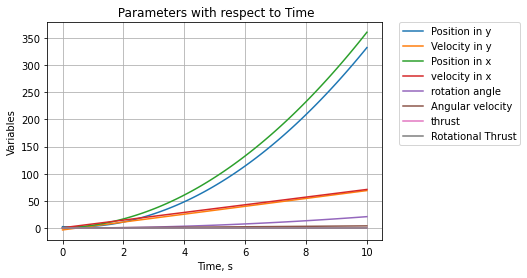

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[51] loss: 250542.062


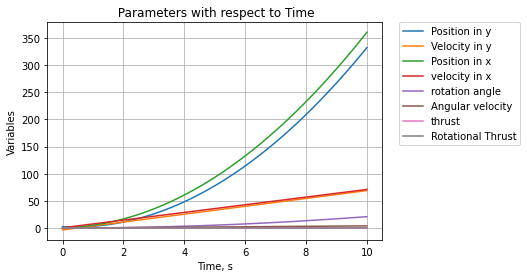

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[52] loss: 250542.031


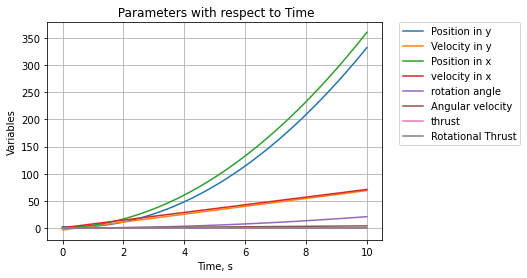

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[53] loss: 250542.000


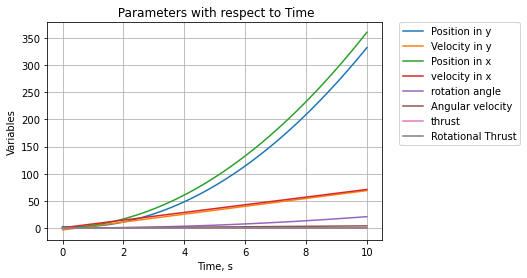

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[54] loss: 250541.969


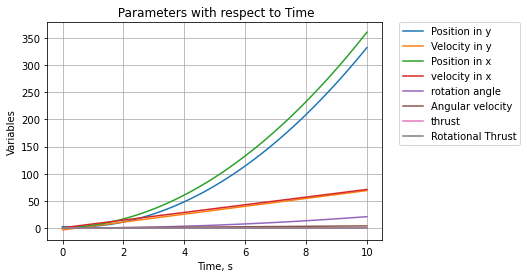

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[55] loss: 250541.969


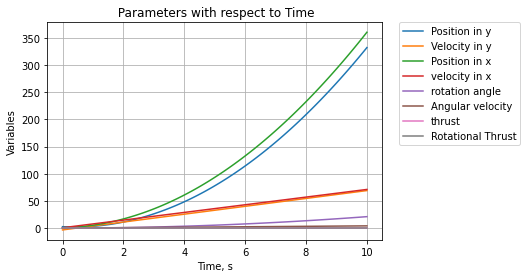

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[56] loss: 250541.938


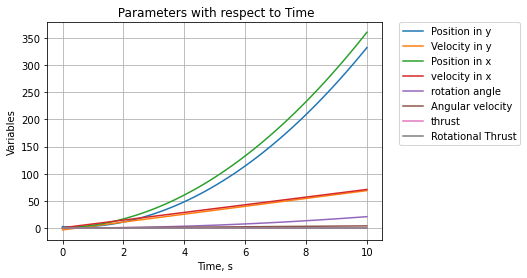

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[57] loss: 250541.906


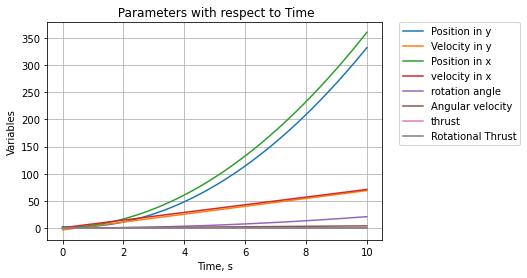

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[58] loss: 250541.875


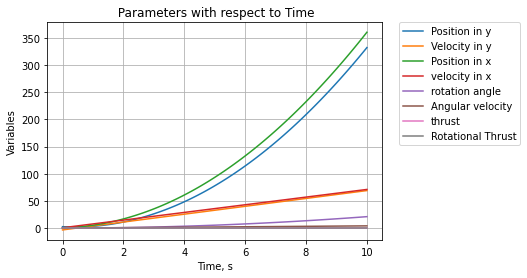

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[59] loss: 250541.844


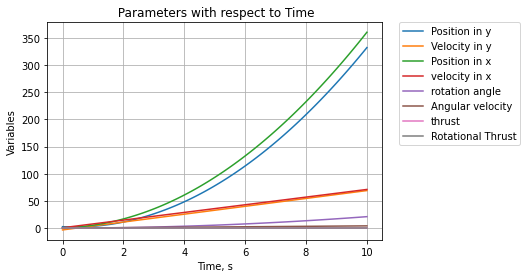

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[60] loss: 250541.812


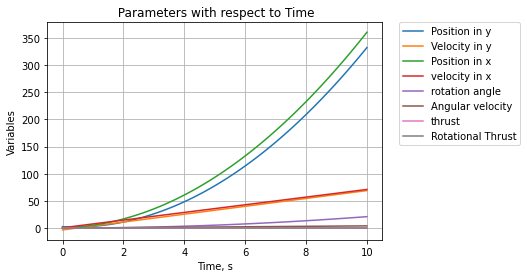

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[61] loss: 250541.812


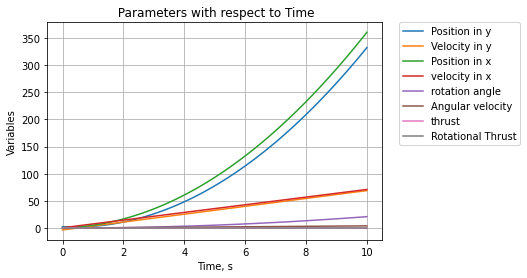

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[62] loss: 250541.781


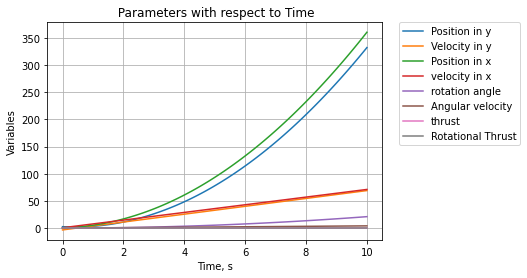

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[63] loss: 250541.750


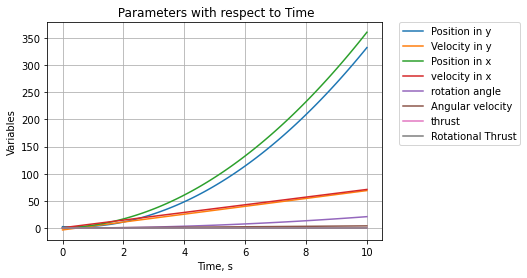

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[64] loss: 250541.750


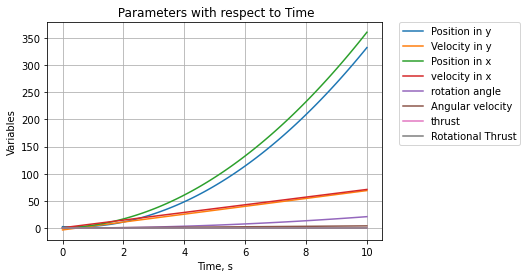

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[65] loss: 250541.719


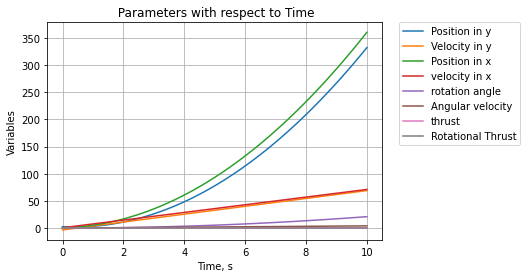

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[66] loss: 250541.719


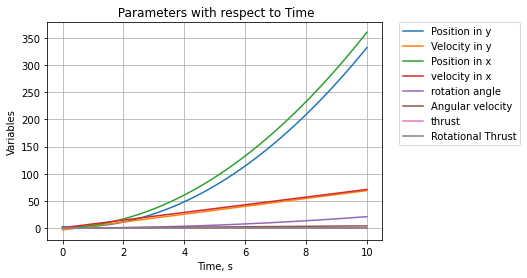

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[67] loss: 250541.688


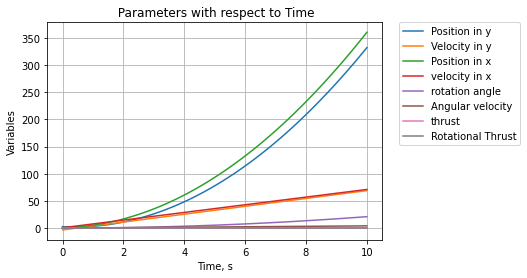

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[68] loss: 250541.656


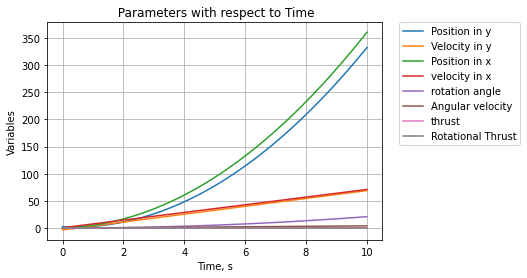

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[69] loss: 250541.656


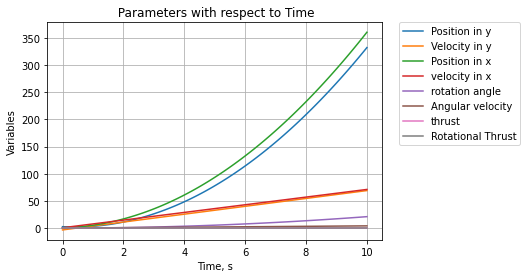

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[70] loss: 250541.625


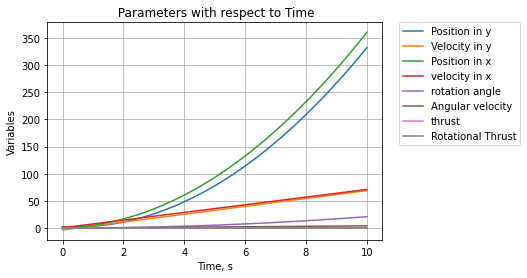

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[71] loss: 250541.625


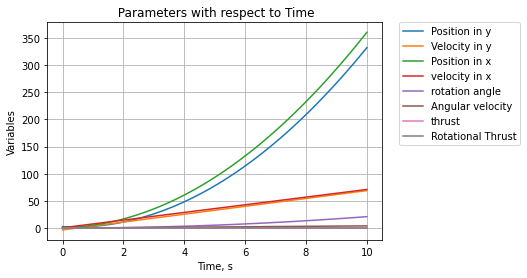

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[72] loss: 250541.594


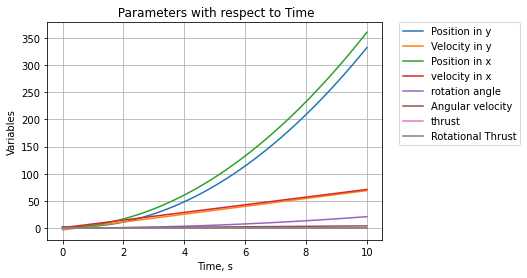

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[73] loss: 250541.594


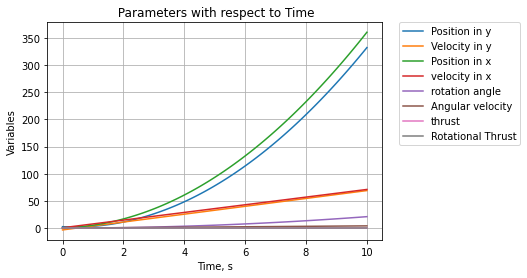

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[74] loss: 250541.562


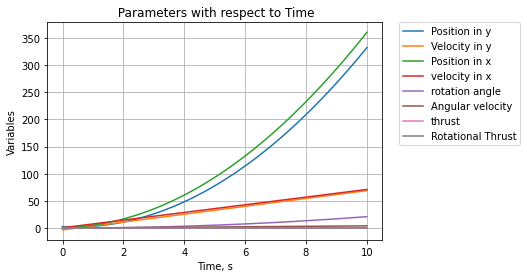

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[75] loss: 250541.562


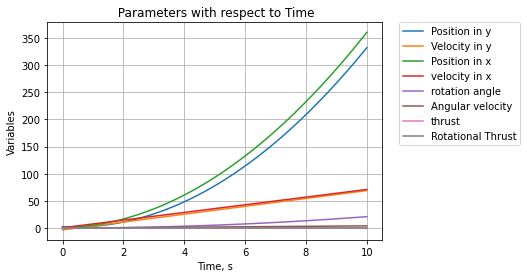

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[76] loss: 250541.531


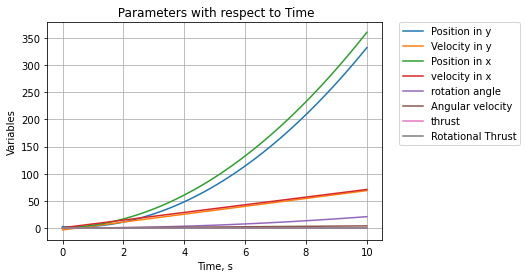

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[77] loss: 250541.531


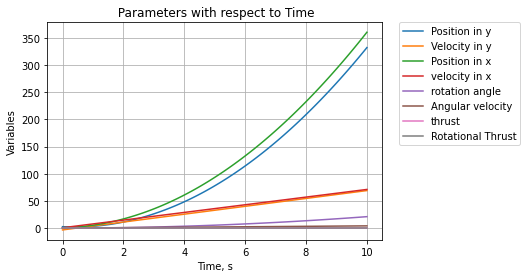

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[78] loss: 250541.500


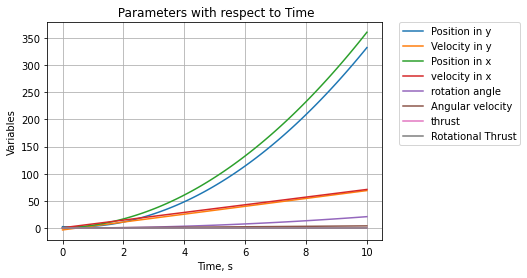

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[79] loss: 250541.500


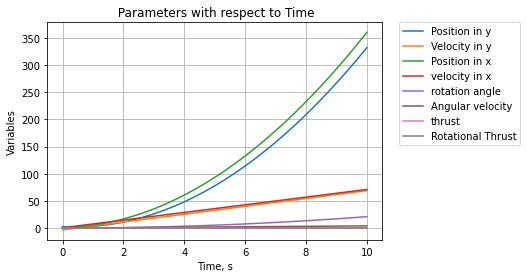

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[80] loss: 250541.469


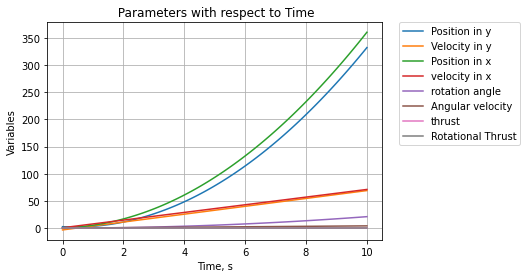

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[81] loss: 250541.469


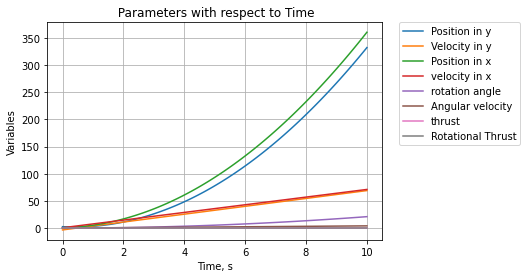

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[82] loss: 250541.438


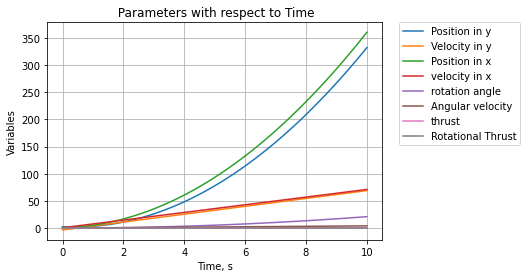

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[83] loss: 250541.438


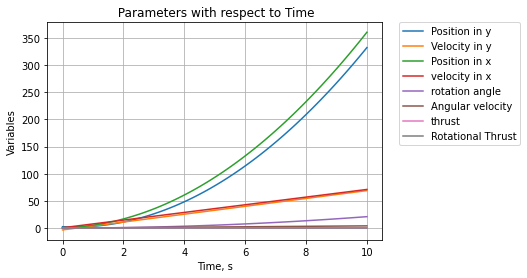

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[84] loss: 250541.438


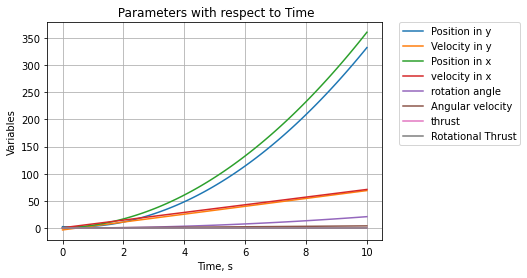

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[85] loss: 250541.406


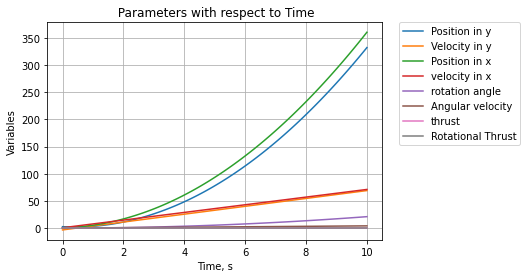

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[86] loss: 250541.406


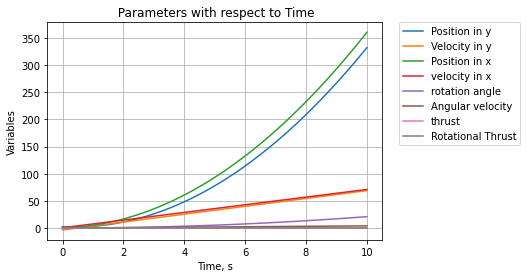

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[87] loss: 250541.375


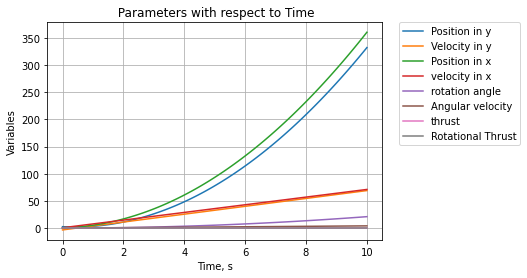

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[88] loss: 250541.375


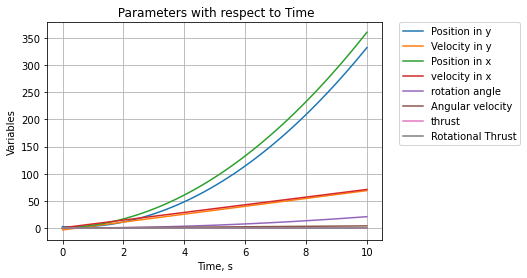

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[89] loss: 250541.375


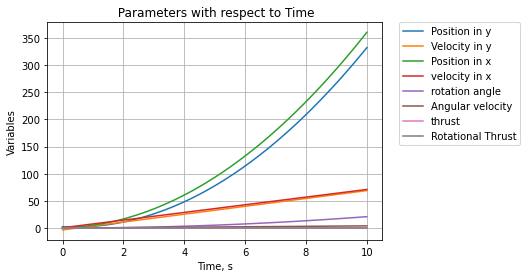

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
[90] loss: 250541.344


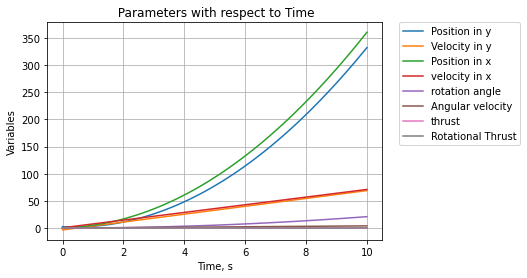

In [23]:


import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

"""
OPTIMIZATION OF DYNAMIC MODEL OF AN ATLAS V ROCKET..
                             
The model of an Atlas V is Chosen and the probelem is action parameeters like thrust and rotational thrust are solved and plotted 
with the defined state variables..


This is the problem formualtion of rocket landing and the paramaters and dimensions have been considered from the 
website of NASA. I have manipulated the distance function and optimized it accordingly by verifying the loss pattern.

Hence this is a new dynamic model of Atlas V rocket


I have experimented a set of neural networks and successfully optimized the loss..

Although the loss is higher intially which is due to the reason that I don't consider the complete physics behind the model,
It makes sense when the loss is decreasing which tells us the our optimization is successfull...



"""


# environment parameters

time = 0.1  # time interval
acc_gravity = 9.81  # constant
acc_boost = 10  # thrust constant
acc_rot = 89*math.pi/180
# define system dynamics
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        
        DYNAMIC PARAMETER USED HERE 
        
        state[0] = dispalacement in y
        
        state[1] = velocity in y
        
        state[2] = displacement in x
        
        state[3] = velocity in x 
        
        state[4] = Direction
        
        state[5] =  Angular Velocity
        
        action[0] = Thrust in y
        
        action[1] = Thrust in x
        
        action[2] = Rotational thrust

      
        """
        
        # Apply gravity
        
        delta_state_gravity = t.tensor([0., acc_gravity * time , 0., 0.,0.,0.])


        delta_state_y = acc_boost * time * t.tensor([0., -1., 0., 0.,0.,0.]) * action[0] 
        
        delta_state_x = acc_boost * time * t.tensor([0.,0., 0., 1.,0.,0.]) * action[1]  

        delta_state_rotation = acc_rot * time * t.tensor([0., 0., 0., 0., 0., 1.]) * action[2]

        temp = delta_state_y #redundancy parameter
        
        """"
        In the given rocket landing scenario, the lift force of the rocket is being calculated

        Aerodynamic_Drag_force: D = Cd * Area_wing * .5 * r * V^2
        Atlas rocket is being considered in the scenario
        Cd = 0.75 (Drag co-efficient)
        The diameter of the Atlas v rocket is 3.8 m,
        Area = pi * 1.9 m ^2  = 11.33 m^2
        r = 850 kg/m^3 (Density of steel)
        V = velocity = delta_state
               m = 590000 Kg (Weight of Atlas V rocket)

               D = 0.75 * 11.33 * 0.5 * 850 * delta_state**2
               Let me assume the velocit as 10 m/s^2

               also applying force balance on the rocket

               m * DRAG_ACC (Negative acceleration due to gravity) = D
               DRAG_ACC = 0.00612 * delta_state**2
               Rev Acceleration due to Drag =  Drag_Force/ mass = 0.01627 * Vel^2
               
               
               Mach Number 
               M = velocity of sound/ velocity of the rocket
               
               The values of M are not printed as it is increasing the complexity..
               But the code is working fine with it..I have commented the Mach Number part after the velocity state for your ref..

        """""

        decel_drag = 0.01627 * temp * temp

        acc_net = acc_boost - decel_drag

        delta_state_yn = acc_net * time * t.tensor([0., -1, 0., 0.,0.,0.]) * action[0] 


        state = state + delta_state_yn + delta_state_x + delta_state_rotation + delta_state_gravity

        matrix = t.tensor([[1., time, 0., 0., 0., 0.],
                            [0., 1., 0., 0., 0., 0.],
                            [0., 0., 1., time, 0., 0.],
                            [0., 0., 0., 1., 0., 0.],
                            [0., 0., 0., 0., 1., time],
                            [0., 0., 0., 0., 0., 1.]])
        state = t.matmul(matrix, state)

        return state
    
    
class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        
        """
        NEURAL NETWORK 
        
        
        Neural networks are essentially self-optimizing functions that map inputs to the correct outputs.
        We can then place a new input into the function, 
        where it will predict an output based on the function it created with the training data.

        
        I have experimented the neural networks 
        By starting with a simple step..
        I went on using as per nn.sequential
        
        
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Sigmoid(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Tanh(),
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
                state = [0.79, 0., 3., -4.,0.,0.]  # TODO: need batch of initial states
                return t.tensor(state, requires_grad=False).float()

    def error(self, state):
      loss = t.sum(t.square(state))
      return loss
class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            self.visualize()

    def visualize(self):
    # Establishing data arrays to plot
        statedata = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        actiondata = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        Time = FRAME_TIME * np.linspace(0,T,T)
        x = statedata[:, 0]
        xdot = statedata[:, 1]
        y = statedata[:, 2]
        ydot = statedata[:, 3]
        rot = statedata[:, 4]
        rotdot = statedata[:, 5]
        thrust = actiondata[:, 0]
        rotthrust = actiondata[:,1]
      
        # Creating the plot for each of the state variables
        f1 = plt.figure()
        ax1 = f1.add_subplot(111)
        ax1.plot(Time, y, label = 'Position in y')
        ax1.plot(Time, ydot, label = 'Velocity in y')
        ax1.plot(Time, x, label = 'Position in x')
        ax1.plot(Time, xdot, label = 'velocity in x')
        ax1.plot(Time, rot, label = 'rotation angle')
        ax1.plot(Time, rotdot, label = 'Angular velocity')
        ax1.plot(Time, thrust, label = 'thrust')
        ax1.plot(Time, rotthrust, label = 'Rotational Thrust')        
        plt.xlabel('Time, s')
        plt.ylabel('Variables')
        plt.title(' Parameters with respect to Time')
        plt.grid(True)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
      
        
      
        plt.show()
# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 9  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(90)  # solve the optimization problem

## 3. A Better Problem Formulation

Here is a list of things we discussed during the class that could help to make the problem more representative of the reality:

1. More realistic definition of state and action spaces: Rocket orientation, angular velocity, etc. 
2. Better dynamical model, e.g., drag
3. Constraints in state and action spaces
4. Controller design for a distribution of initial states rather than one
5. Randomness in dynamics, sensing, etc.
6. Discontinuity in modeling so that gradient cannot be computed, e.g., mechanical failures.

In this project, please choose at least one aspect from 1 to 5 from the list to improve your problem formulation and solve the resultant problem. We will address 6 when we talk about reinforcement learning.

Here is one example of problem formulation when we consider randomness in dynamics and initial states:

$$
\begin{aligned}
\min_{\theta} \quad & \mathbb{E}_{\{w(t), u(t), x(0)\}}\left[||x(T)||^2\right] \\
\quad & d(t+1) = d(t) + v(t) + w(t) \Delta t, \\
\quad & v(t+1) = v(t) + a(t) + u(t) \Delta t, \\
\quad & a(t) = f_{\theta}(x(t)), ~\forall t=1,...,T-1 \\
\quad & x(1) \sim \Pr(x(1))
\end{aligned}
$$

Here $w(t) \sim \Pr(w(t))$ and $u(t) \sim \Pr(u(t))$ are modeled as i.i.d. noises added to the dynamics, and $\Pr(x(1))$ is the distribution of initial states. We will approximate this problem using samples from $\Pr(w(t))$, $\Pr(u(t))$, and $\Pr(x(1))$. To do so, we sample $\{w(1)^{(i)},w(2)^{(i)},...,w(T)^{(i)}\}_{i}^N$ from $\Pr(w(t))$,  $\{u(1)^{(i)},u(2)^{(i)},...,u(T)^{(i)}\}_{i}^N$ from $\Pr(u(t))$, and $\{x(0)^{(i)}\}_{i}^N$ from $\Pr(x(1))$, where $N$ is the number of samples to be considered. Then we have the following problem instead:

$$
\begin{aligned}
\min_{\theta} \quad & \frac{1}{N}\sum_{i=1}^N ||x^{(i)}(T)||^2 \\
\quad & d(t+1)^{(i)} = d(t)^{(i)} + v(t)^{(i)} + w(t)^{(i)} \Delta t, \\
\quad & v(t+1)^{(i)} = v(t)^{(i)} + a(t)^{(i)} + u(t)^{(i)} \Delta t, \\
\quad & a(t)^{(i)} = f_{\theta}(x(t)^{(i)}), ~\forall t=1,...,T-1, ~i=1,...,N \\
\end{aligned}
$$

The code up this new problem, you will fully utilize the tensor operations in PyTorch. For example, the state tensor "x" will now become a N-by-2 matrix, where the first dimension represents the number of trajectories to be optimized. 

## 4. Grading

* (30%) Documentation of the problem formulation: Clearly describe the objective function, the variables, the constraints, and the assumptions involved in formulating the problem.

* (40%) Programming: Like for homeworks, please push you code to your github repo. Please comment your code so that it is useful to you in the future.

* (30%) Analysis of the results: Please document the convergence and the optimal solutions (e.g., the state trajectory if it is a control problem).

* (Bonus 20%) Formulation of a problem different from rocket landing: The PyTorch framework can also be used for other engineering problems, e.g., for structure design with nonlinear mechanical properties. You get 20 bonus points for solving your own problems that are at least at the same level of difficulty as rocket landing. 